### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
# 載入套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    # dropna():去掉含有缺失值的樣本
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    # pd.DataFrame.apply（）:用於將給定函數應用於整個DataFrame
    # np.fromstring:將字符轉化成nd.array對象
    # np.values:讀取內部的值
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    # np.vstack:沿著垂直方向將矩陣堆疊起來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
# 載入套件
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [6]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    # 建立卷積層，filter=16,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    # 建立卷積層，filter=32,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    
    # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    
    # 建立卷積層，filter=128,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    
    # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
    model.add(Flatten())
    # 全連接層: 512個output
    model.add(Dense(512, activation='relu'))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.2
    model.add(Dropout(0.2))
    # 全連接層: 512個output
    model.add(Dense(512, activation='relu'))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.2
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    # 全連接層: 30個output
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [9]:
# 載入套件
from keras.callbacks import ModelCheckpoint, History
# model checkpoint
# ModelCheckpoint: 在每個訓練期之後保存模型。
""" 
ModelCheckpoint 參數說明:
verbose :詳細信息模式，0或者1 。
save_weights_only :如果True，那麼只有模型的權重會被保存( model.save_weights(filepath))，否則的話，整個模型會被保存( model.save(filepath))。
"""
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
# History():把所有事件都記錄到History對象的回調函數。
hist = History()

In [10]:
# training the model
# model.fit():此函數用以訓練模型
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1),  #輸入數據
                       points_train, #標籤
                       validation_split=0.2,  #用來指定訓練集的20%數據作為驗證集
                       batch_size=64, #指定進行梯度下降時每個batch包含的樣本數為64
                       callbacks=[checkpoint, hist], #回調函數
                       shuffle=True,  #是否在訓練過程中每個epoch前隨機打亂輸入樣本的順序
                       epochs=150, #訓練終止時的epoch值，訓練將在達到該epoch值時停止
                       verbose=1) #日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄
# save the model weights
model.save_weights('weights.h5')
# save the model
# model.save:將Keras模型與權重保存在一個HDF5檔案中
model.save('model.h5')


Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 4s 2ms/step - loss: 0.0082 - val_loss: 0.0028

Epoch 00001: val_loss improved from inf to 0.00277, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 397us/step - loss: 0.0022 - val_loss: 0.0020

Epoch 00002: val_loss improved from 0.00277 to 0.00201, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 1s 395us/step - loss: 0.0015 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00201 to 0.00194, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 1s 391us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00194 to 0.00187, saving model to best_weights.h5
Epoch 5/150
1712/1712 [==============================] - 1s 407us/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00005: val_loss improved from 0.00187 to 0.00187, saving model to best

1712/1712 [==============================] - 1s 401us/step - loss: 2.1813e-04 - val_loss: 7.6232e-04

Epoch 00043: val_loss did not improve from 0.00075
Epoch 44/150
1712/1712 [==============================] - 1s 410us/step - loss: 2.0891e-04 - val_loss: 7.9242e-04

Epoch 00044: val_loss did not improve from 0.00075
Epoch 45/150
1712/1712 [==============================] - 1s 415us/step - loss: 2.0941e-04 - val_loss: 7.7183e-04

Epoch 00045: val_loss did not improve from 0.00075
Epoch 46/150
1712/1712 [==============================] - 1s 426us/step - loss: 2.1183e-04 - val_loss: 7.8186e-04

Epoch 00046: val_loss did not improve from 0.00075
Epoch 47/150
1712/1712 [==============================] - 1s 424us/step - loss: 2.1062e-04 - val_loss: 7.5774e-04

Epoch 00047: val_loss did not improve from 0.00075
Epoch 48/150
1712/1712 [==============================] - 1s 443us/step - loss: 1.9826e-04 - val_loss: 7.9252e-04

Epoch 00048: val_loss did not improve from 0.00075
Epoch 49/150
1712

1712/1712 [==============================] - 1s 417us/step - loss: 1.2863e-04 - val_loss: 7.3327e-04

Epoch 00091: val_loss did not improve from 0.00071
Epoch 92/150
1712/1712 [==============================] - 1s 398us/step - loss: 1.2614e-04 - val_loss: 7.5640e-04

Epoch 00092: val_loss did not improve from 0.00071
Epoch 93/150
1712/1712 [==============================] - 1s 394us/step - loss: 1.2595e-04 - val_loss: 7.5129e-04

Epoch 00093: val_loss did not improve from 0.00071
Epoch 94/150
1712/1712 [==============================] - 1s 393us/step - loss: 1.3140e-04 - val_loss: 7.5164e-04

Epoch 00094: val_loss did not improve from 0.00071
Epoch 95/150
1712/1712 [==============================] - 1s 393us/step - loss: 1.2481e-04 - val_loss: 7.3843e-04

Epoch 00095: val_loss did not improve from 0.00071
Epoch 96/150
1712/1712 [==============================] - 1s 391us/step - loss: 1.2196e-04 - val_loss: 7.3119e-04

Epoch 00096: val_loss did not improve from 0.00071
Epoch 97/150
1712

1712/1712 [==============================] - 1s 419us/step - loss: 9.3603e-05 - val_loss: 7.2551e-04

Epoch 00140: val_loss did not improve from 0.00071
Epoch 141/150
1712/1712 [==============================] - 1s 413us/step - loss: 9.1975e-05 - val_loss: 7.2891e-04

Epoch 00141: val_loss did not improve from 0.00071
Epoch 142/150
1712/1712 [==============================] - 1s 418us/step - loss: 9.2405e-05 - val_loss: 7.3108e-04

Epoch 00142: val_loss did not improve from 0.00071
Epoch 143/150
1712/1712 [==============================] - 1s 422us/step - loss: 9.3120e-05 - val_loss: 7.3439e-04

Epoch 00143: val_loss did not improve from 0.00071
Epoch 144/150
1712/1712 [==============================] - 1s 418us/step - loss: 9.0829e-05 - val_loss: 7.4506e-04

Epoch 00144: val_loss did not improve from 0.00071
Epoch 145/150
1712/1712 [==============================] - 1s 415us/step - loss: 9.0160e-05 - val_loss: 7.3383e-04

Epoch 00145: val_loss did not improve from 0.00071
Epoch 146/15

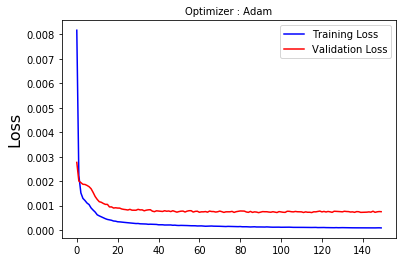

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [12]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [13]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

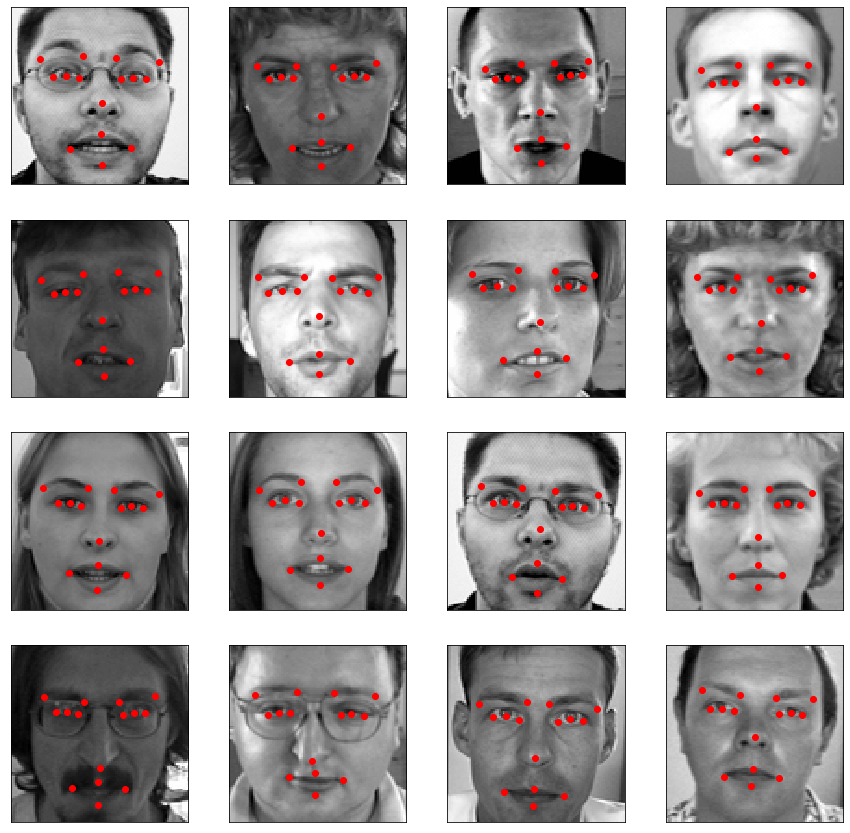

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    # np.squeeze:從陣列的形狀中刪除單維度條目
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [15]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
# Your code
# Your code here
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, points):
    rows, cols = img.shape
    # np.copy(img)複製圖片
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    # np.copy(points):複製關鍵點
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

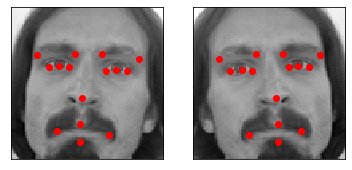

In [17]:

flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

# 製作空白的figure來製作圖中圖
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[]) #xticks=[]:x軸刻度、yticks=[]:y軸刻度
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) #xticks=[]:x軸刻度、yticks=[]:y軸刻度
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [18]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [19]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
# training the model
# model.fit():此函數用以訓練模型
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), # 輸入數據 
                                        aug_points_train,  # 標籤
                                        validation_split=0.2, # 用來指定訓練集的一定比例數據作為驗證集
                                        batch_size=64, # 指定進行梯度下降時每個batch包含的樣本數。
                                        callbacks=[checkpoint_aug, hist],
                                        shuffle=True, #表示是否在訓練過程中每個epoch前隨機打亂輸入樣本的順序
                                        epochs=150, #訓練終止時的epoch值，訓練將在達到該epoch值時停止，
                                        verbose=1) #日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 2s 628us/step - loss: 0.0038 - val_loss: 0.0020

Epoch 00001: val_loss improved from inf to 0.00197, saving model to best_weights_augment.h5
Epoch 2/150
3424/3424 [==============================] - 1s 400us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00197 to 0.00191, saving model to best_weights_augment.h5
Epoch 3/150
3424/3424 [==============================] - 1s 422us/step - loss: 0.0011 - val_loss: 0.0018

Epoch 00003: val_loss improved from 0.00191 to 0.00177, saving model to best_weights_augment.h5
Epoch 4/150
3424/3424 [==============================] - 1s 416us/step - loss: 8.4215e-04 - val_loss: 0.0014

Epoch 00004: val_loss improved from 0.00177 to 0.00137, saving model to best_weights_augment.h5
Epoch 5/150
3424/3424 [==============================] - 1s 405us/step - loss: 6.3762e-04 - val_loss: 0.0011

Epoch 00005: val_loss improved from

3424/3424 [==============================] - 1s 394us/step - loss: 1.4288e-04 - val_loss: 6.1829e-04

Epoch 00044: val_loss did not improve from 0.00060
Epoch 45/150
3424/3424 [==============================] - 1s 400us/step - loss: 1.4123e-04 - val_loss: 6.1284e-04

Epoch 00045: val_loss did not improve from 0.00060
Epoch 46/150
3424/3424 [==============================] - 1s 419us/step - loss: 1.3744e-04 - val_loss: 6.4221e-04

Epoch 00046: val_loss did not improve from 0.00060
Epoch 47/150
3424/3424 [==============================] - 1s 420us/step - loss: 1.3328e-04 - val_loss: 6.0684e-04

Epoch 00047: val_loss did not improve from 0.00060
Epoch 48/150
3424/3424 [==============================] - 1s 429us/step - loss: 1.3446e-04 - val_loss: 6.1923e-04

Epoch 00048: val_loss did not improve from 0.00060
Epoch 49/150
3424/3424 [==============================] - 1s 418us/step - loss: 1.3249e-04 - val_loss: 6.2416e-04

Epoch 00049: val_loss did not improve from 0.00060
Epoch 50/150
3424

3424/3424 [==============================] - 1s 381us/step - loss: 8.8521e-05 - val_loss: 6.0123e-04

Epoch 00092: val_loss did not improve from 0.00058
Epoch 93/150
3424/3424 [==============================] - 1s 399us/step - loss: 8.9199e-05 - val_loss: 5.8895e-04

Epoch 00093: val_loss did not improve from 0.00058
Epoch 94/150
3424/3424 [==============================] - 1s 427us/step - loss: 8.9047e-05 - val_loss: 5.8614e-04

Epoch 00094: val_loss did not improve from 0.00058
Epoch 95/150
3424/3424 [==============================] - 1s 413us/step - loss: 8.9027e-05 - val_loss: 6.0460e-04

Epoch 00095: val_loss did not improve from 0.00058
Epoch 96/150
3424/3424 [==============================] - 1s 398us/step - loss: 8.6559e-05 - val_loss: 6.1227e-04

Epoch 00096: val_loss did not improve from 0.00058
Epoch 97/150
3424/3424 [==============================] - 1s 393us/step - loss: 8.6813e-05 - val_loss: 5.9679e-04

Epoch 00097: val_loss did not improve from 0.00058
Epoch 98/150
3424

3424/3424 [==============================] - 1s 392us/step - loss: 7.2407e-05 - val_loss: 6.0245e-04

Epoch 00141: val_loss did not improve from 0.00058
Epoch 142/150
3424/3424 [==============================] - 1s 392us/step - loss: 7.3900e-05 - val_loss: 6.1234e-04

Epoch 00142: val_loss did not improve from 0.00058
Epoch 143/150
3424/3424 [==============================] - 1s 390us/step - loss: 7.2498e-05 - val_loss: 6.3809e-04

Epoch 00143: val_loss did not improve from 0.00058
Epoch 144/150
3424/3424 [==============================] - 1s 394us/step - loss: 7.8098e-05 - val_loss: 6.2414e-04

Epoch 00144: val_loss did not improve from 0.00058
Epoch 145/150
3424/3424 [==============================] - 1s 395us/step - loss: 7.2962e-05 - val_loss: 6.0182e-04

Epoch 00145: val_loss did not improve from 0.00058
Epoch 146/150
3424/3424 [==============================] - 1s 419us/step - loss: 7.1394e-05 - val_loss: 6.2020e-04

Epoch 00146: val_loss did not improve from 0.00058
Epoch 147/15

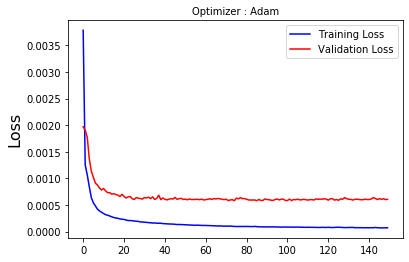

In [20]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

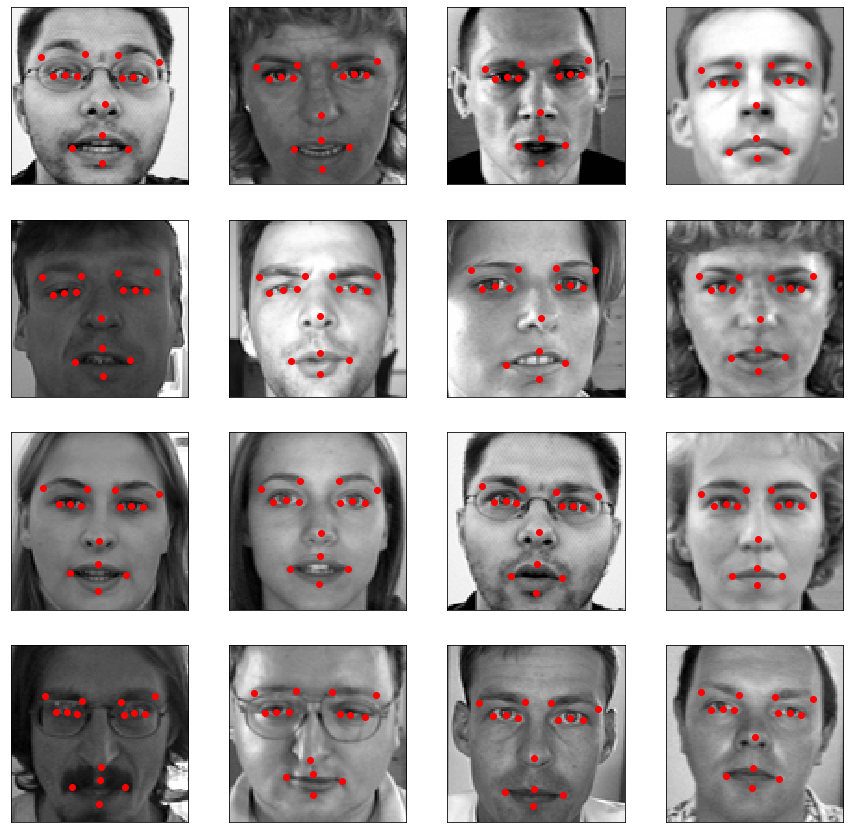

In [21]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))